In [1]:
# matplotlib notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

In [2]:
import matplotlib

In [3]:
datadir = os.getcwd() + '//' + 'results' + '//'
plotdir = os.getcwd() + '//' + 'plots' + '//'

In [99]:
#controlBenchmarks = ['CCa','CCe','CCh','CCh_st','CCl','CCm','CF1','CRd','CRf','CRm','CS1','CS3']
controlBenchmarks = ['CCa','CCe','CCm','CCh','CCh_st','CCl','CS1','CS3']
O3controlBenchmarks = ['CCa','CCe','CCm','CCh','CCh_st','CCl','CS1']
memoryTypes = ['Inf', 'SingleCycle', 'Slow']
O3memoryTypes = ['Inf']
cpuTypes1 = ['Simple']
cpuTypes2 = ['O3']
branchPredictors = ['Local','BiMode', 'Tournament', 'LTAGE']
#branchPredictors = ['Bimode']

In [72]:
# function to extract stats
def gem5GetStat(filename, stat):
    filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    with open(filename) as f:
        r = f.read()
        if len(r) < 10: return 0.0
        start = r.find(stat) + len(stat) + 1
        end = r.find('#', start)
        return float(r[start:end])

In [73]:
# data frame for KVM CPU
rows = []
for mem in memoryTypes:
    for bm in controlBenchmarks:
        for cpu in cpuTypes1:
            for bp in branchPredictors:
                cdir = datadir  + mem + '//' + bm + '//' + cpu + '//' + 'Simple_' + bp
                rows.append([mem, bm, cpu, bp, 
                             gem5GetStat(cdir, 'sim_insts'),
                             gem5GetStat(cdir, 'sim_ticks')/1e12,
                             gem5GetStat(cdir, 'system.cpu.BranchMispred'),
                             gem5GetStat(cdir, 'system.cpu.Branches'),
                             gem5GetStat(cdir, 'system.cpu.branchPred.BTBLookups'),        # Number of BTB lookups
                             gem5GetStat(cdir, 'system.cpu.branchPred.RASInCorrect'),      # Number of incorrect RAS predictions.
                             gem5GetStat(cdir, 'system.cpu.branchPred.usedRAS'),           # Number of times the RAS was used to get a target
                             gem5GetStat(cdir, 'system.cpu.branchPred.condIncorrect'),
                             gem5GetStat(cdir, 'system.cpu.branchPred.condPredicted'),
                             gem5GetStat(cdir, 'system.cpu.branchPred.indirectHits'),
                             gem5GetStat(cdir, 'system.cpu.branchPred.indirectLookups'),
                             gem5GetStat(cdir, 'system.cpu.branchPred.indirectMisses'),
                             gem5GetStat(cdir, 'system.cpu.branchPredindirectMispredicted'),
                             gem5GetStat(cdir, 'system.cpu.branchPred.lookups')]) 
                
                
df_Simple = pd.DataFrame(rows, columns=['memoryType', 'benchmark', 'cpu', 'bp', 'instructions', 'sim_time', 'BranchMispredicted',
                                         'noOfBranches', 'BTBLookups','RASInCorrect', 'RASused', 'condIncorrect', 
                                         'condPredicted', 'indirectHits', 'indirectLookups','indirectMisses','indirectMispredicted', 
                                         'lookups'])
df_Simple['condMissRate'] = (df_Simple['condIncorrect']/df_Simple['condPredicted'])*100
df_Simple['noOfUncond'] = (df_Simple['noOfBranches'] - df_Simple['condPredicted'])
df_Simple['indirectMissRate'] = (df_Simple['indirectMispredicted']/df_Simple['indirectHits'])*100
df_Simple['branchMissRate'] = ((df_Simple['BranchMispredicted'])/(df_Simple['noOfBranches']))*100
df_Simple['noOfDirectBranches'] = ((df_Simple['BTBLookups']) - (df_Simple['indirectLookups']))


In [100]:
# data frame for KVM CPU
rows = []
for mem in O3memoryTypes:
    for bm in O3controlBenchmarks:
        for cpu in cpuTypes2:
            for bp in branchPredictors:
                cdir = datadir  + 'O3//' + mem + '//' + bm + '//' + cpu + '//' + 'DefaultO3_' + bp                
                rows.append([mem, bm, cpu, bp, 
                             gem5GetStat(cdir, 'sim_insts'),
                             gem5GetStat(cdir, 'sim_ticks')/1e12,
                             gem5GetStat(cdir, 'system.cpu.branchPred.usedRAS'),           # Number of times the RAS was used to get a target
                             gem5GetStat(cdir, 'system.cpu.branchPred.condIncorrect'),
                             gem5GetStat(cdir, 'system.cpu.branchPred.condPredicted'),
                             gem5GetStat(cdir, 'system.cpu.branchPred.indirectHits'),
                             gem5GetStat(cdir, 'system.cpu.branchPred.indirectLookups'),
                             gem5GetStat(cdir, 'system.cpu.branchPred.indirectMisses'),
                             gem5GetStat(cdir, 'system.cpu.branchPredindirectMispredicted'),
                             gem5GetStat(cdir, 'system.cpu.branchPred.lookups'),
                             gem5GetStat(cdir, 'system.cpu.ipc'),
                             gem5GetStat(cdir, 'system.cpu.commit.branches'),
                             gem5GetStat(cdir, 'system.cpu.commit.branchMispredicts')]) 
                
                
                
df_O3 = pd.DataFrame(rows, columns=['memoryType', 'benchmark', 'cpu', 'bp', 'instructions', 'sim_time', 'RASused', 'condIncorrect', 
                                         'condPredicted', 'indirectHits', 'indirectLookups','indirectMisses','indirectMispredicted', 
                                         'lookups', 'ipc', 'noOfBranches', 'branchMispredicts'])
df_O3['condMissRate'] = (df_O3['condIncorrect']/df_O3['condPredicted'])*100
df_O3['indirectMissRate'] = (df_O3['indirectMispredicted']/df_O3['indirectHits'])*100
df_O3['branchMissRate'] = (df_O3['branchMispredicts']/df_O3['noOfBranches'])*100


In [56]:
def plot_bar_Simple(mems, benchmarks, bps, stat, norm=True):
    plt.figure()
    i = 0
    for mem in mems:
        for bm in benchmarks:
            for cpu in cpuTypes1:
                for j, bp in enumerate(bps):
                    if norm: 
                        base = df_Simple[(df_control['memoryType']==mem)][stat].iloc[0]
                    else: base = 1
                    a = df_Simple[(df_Simple['benchmark']==bm) & (df_Simple['memoryType']==mem) & 
                                  (df_Simple['cpu']==cpu) & (df_Simple['bp']==bp) ]
                    plt.bar(i, a[stat].iloc[0]/base, color='C'+str(j))
                    i += 1
                i += 1
    i = 0
    for i,bp in enumerate(bps):
        plt.bar(0,0,color='C'+str(i), label=bp)
        plt.xticks(np.arange(len(benchmarks))*(len(bps)+1)+i/2, benchmarks, rotation=40, ha='right')

In [57]:
def plot_bar_O3(mems, benchmarks, bps, stat, norm=True):
    plt.figure()
    i = 0
    for mem in mems:
        for bm in benchmarks:
            for cpu in cpuTypes2:
                for j, bp in enumerate(bps):
                    if norm: 
                        base = df_O3[(df_control['memoryType']==mem)][stat].iloc[0]
                    else: base = 1
                    a = df_O3[(df_O3['benchmark']==bm) & (df_O3['memoryType']==mem) & 
                                  (df_O3['cpu']==cpu) & (df_O3['bp']==bp) ]
                    plt.bar(i, a[stat].iloc[0]/base, color='C'+str(j))
                    i += 1
                i += 1
    i = 0
    for i,bp in enumerate(bps):
        plt.bar(0,0,color='C'+str(i), label=bp)
        plt.xticks(np.arange(len(benchmarks))*(len(bps)+1)+i/2, benchmarks, rotation=40, ha='right')

In [58]:
def sublplot_bar(mems, benchmarks, bps, stat1, stat2, ax1_title, ax2_title, ax1_ylabel, ax2_ylabel, norm = False):
    # Create Figure and Subplots
    figure, (ax1, ax2) = plt.subplots(1,2, sharey=False, dpi=120)

    # Plot
    i = 0
    for mem in mems:
        for bm in benchmarks:
            for cpu in cpuTypes:
                for j, bp in enumerate(bps):
                    if norm: 
                        base1 = df_control[(df_control['memoryType']==mem)][stat1].iloc[0]
                        base2 = df_control[(df_control['memoryType']==mem)][stat2].iloc[0]
                    else: 
                        base1 = 1
                        base2 = 1
                    a = df_control[(df_control['benchmark']==bm) & (df_control['memoryType']==mem) & 
                                  (df_control['cpu']==cpu) & (df_control['bp']==bp)]
                    ax1.bar(i, a[stat1].iloc[0]/base1, color= 'C'+str(j))
                    ax2.bar(i, a[stat2].iloc[0]/base2, color= 'C'+str(j))
                    i += 1
                i += 1
            
    # Title, X and Y labels  
    x = np.arange(len(benchmarks)+1)
    ax1.set_xticks(x);ax2.set_xticks(x)
    #ax1.set_xticklabels(benchmarks, rotation=40, ha='right');ax2.set_xticklabels(benchmarks, rotation=40, ha='right')
    ax1.set_ylabel(ax1_ylabel);ax2.set_ylabel(ax2_ylabel)
    ax1.set_title(ax1_title);ax2.set_title(ax2_title);

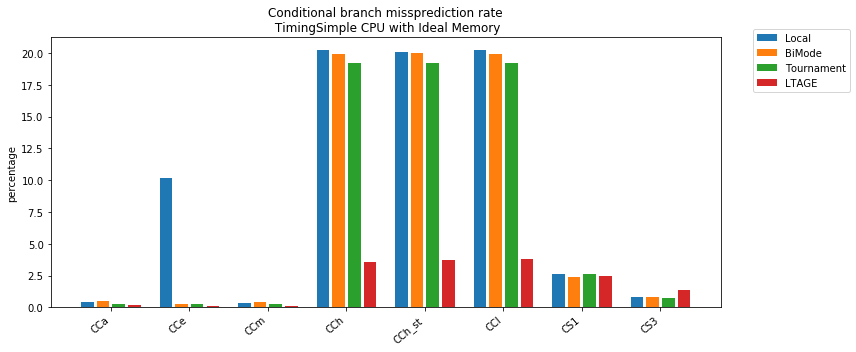

In [86]:
mems = ['Inf']
#benchmarks = ['CCa','CCm','CCe','CCh']
bps = ['Local','BiMode', 'Tournament', 'LTAGE']
stat = 'condMissRate'
plot_title = 'Conditional branch missprediction rate\n TimingSimple CPU with Ideal Memory'
ylabel = 'percentage'

# plot function
plot_bar_Simple(mems, controlBenchmarks, bps, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
plt.savefig(plotdir + stat + '.png', format='png', dpi=600)

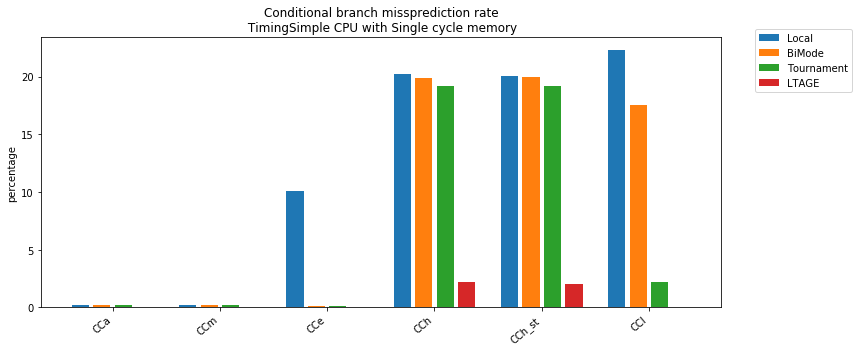

In [85]:
mems = ['SingleCycle']
benchmarks = ['CCa','CCm','CCe','CCh', 'CCh_st', 'CCl']
bps = ['Local','BiMode', 'Tournament', 'LTAGE']
stat = 'condMissRate'
plot_title = 'Conditional branch missprediction rate\n TimingSimple CPU with Single cycle memory'
ylabel = 'percentage'

# plot function
plot_bar_Simple(mems, benchmarks, bps, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
plt.savefig(plotdir + stat + '.png', format='png', dpi=600)

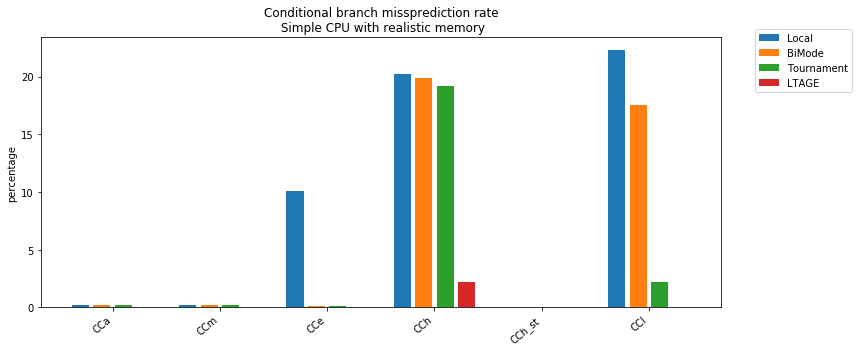

In [84]:
mems = ['Slow']
benchmarks = ['CCa','CCm','CCe','CCh', 'CCh_st', 'CCl']
bps = ['Local','BiMode', 'Tournament', 'LTAGE']
stat = 'condMissRate'
plot_title = 'Conditional branch missprediction rate\n Simple CPU with realistic memory'
ylabel = 'percentage'

# plot function
plot_bar_Simple(mems, benchmarks, bps, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
plt.savefig(plotdir + stat + '.png', format='png', dpi=600)

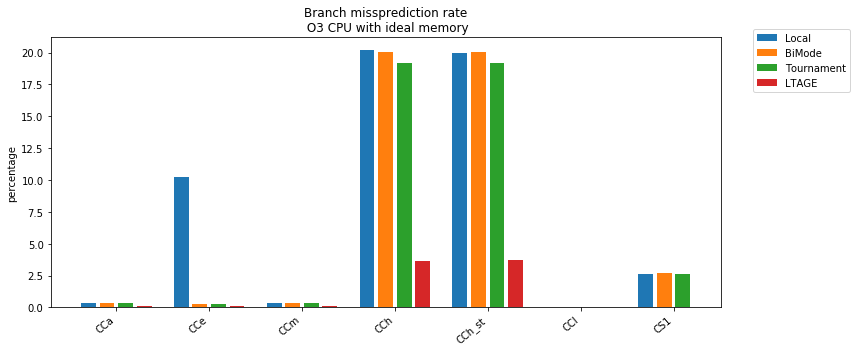

In [103]:
mems = ['Inf']
benchmarks = ['CCa','CCm','CCe','CCh']
bps = ['Local','BiMode', 'Tournament', 'LTAGE']
stat = 'branchMissRate'
plot_title = 'Branch missprediction rate\n O3 CPU with ideal memory'
ylabel = 'percentage'

# plot function
plot_bar_O3(mems, O3controlBenchmarks, bps, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
plt.savefig(plotdir + stat + '.png', format='png', dpi=600)

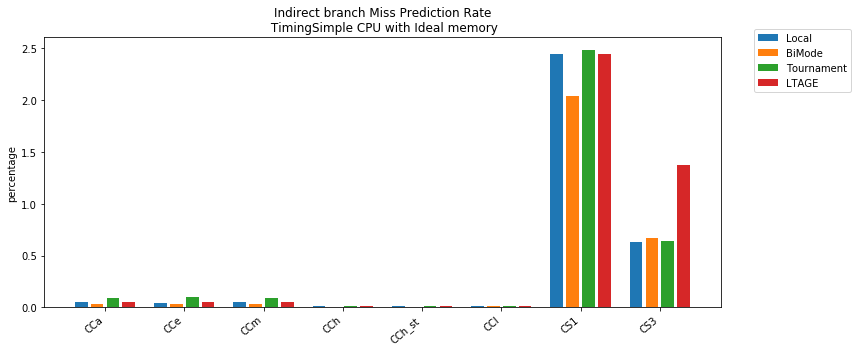

In [92]:
mems = ['Inf']
benchmarks = ['CCa','CCm','CCe']
bps = ['Local','BiMode', 'Tournament', 'LTAGE']
stat = 'indirectMissRate'
plot_title = 'Indirect branch Miss Prediction Rate\n TimingSimple CPU with Ideal memory'
ylabel = 'percentage'

# plot function
plot_bar_Simple(mems, controlBenchmarks, bps, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
plt.savefig(plotdir + 'baised_' + stat + '.png', format='png', dpi=600)

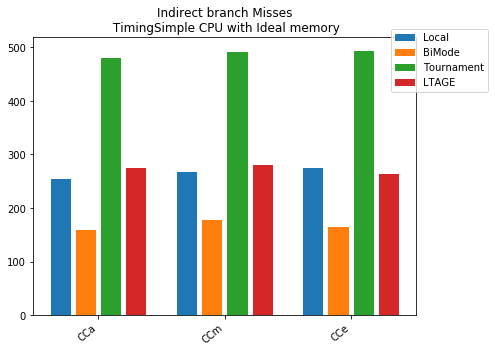

In [94]:
mems = ['Inf']
benchmarks = ['CCa','CCm','CCe']
bps = ['Local','BiMode', 'Tournament', 'LTAGE']
stat = 'indirectMispredicted'
plot_title = 'Indirect branch Misses\n TimingSimple CPU with Ideal memory'
ylabel = ''

# plot function
plot_bar_Simple(mems, benchmarks, bps, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
plt.savefig(plotdir + 'easy_' + stat + '.png', format='png', dpi=600)

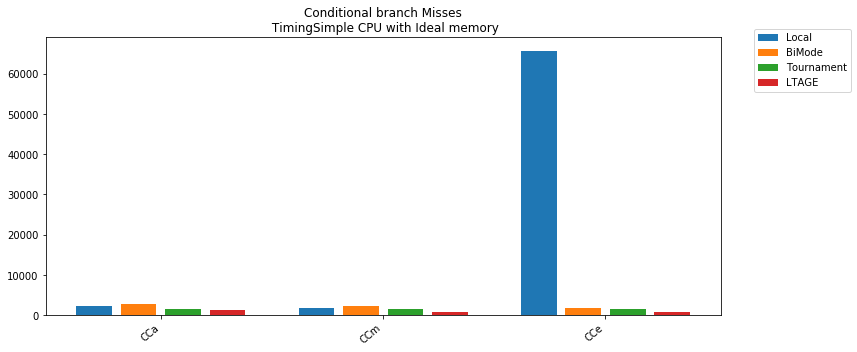

In [104]:
mems = ['Inf']
benchmarks = ['CCa','CCm','CCe']
bps = ['Local','BiMode', 'Tournament', 'LTAGE']
stat = 'condIncorrect'
plot_title = 'Conditional branch Misses\n TimingSimple CPU with Ideal memory'
ylabel = ''

# plot function
plot_bar_Simple(mems, benchmarks, bps, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
plt.savefig(plotdir + 'easy_' + stat + '.png', format='png', dpi=600)